# Среднемесячная зарплата в России

Известны статистические данные о среднемесячной зарплате в России с января 1993 года по август 2016, необходимо построить прогноз на следующие 2 года.

In [72]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


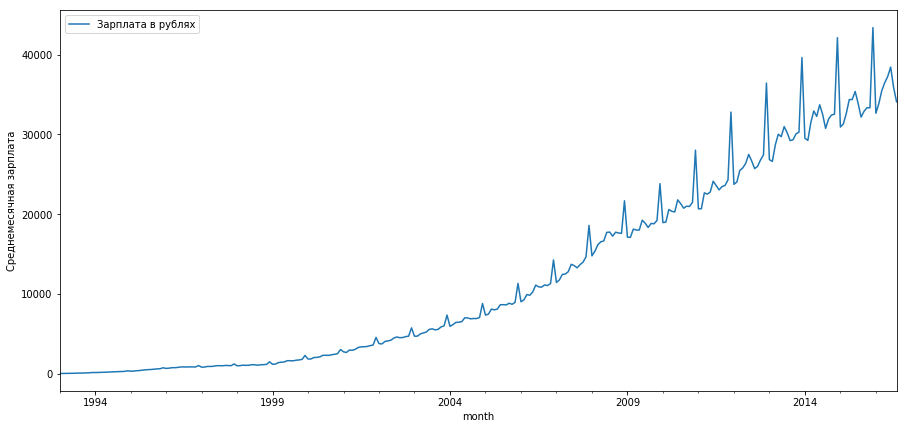

In [82]:
table = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
table.WAG_C_M.plot()
plt.ylabel(u'Среднемесячная зарплата')
plt.legend([u'Зарплата в рублях'])
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


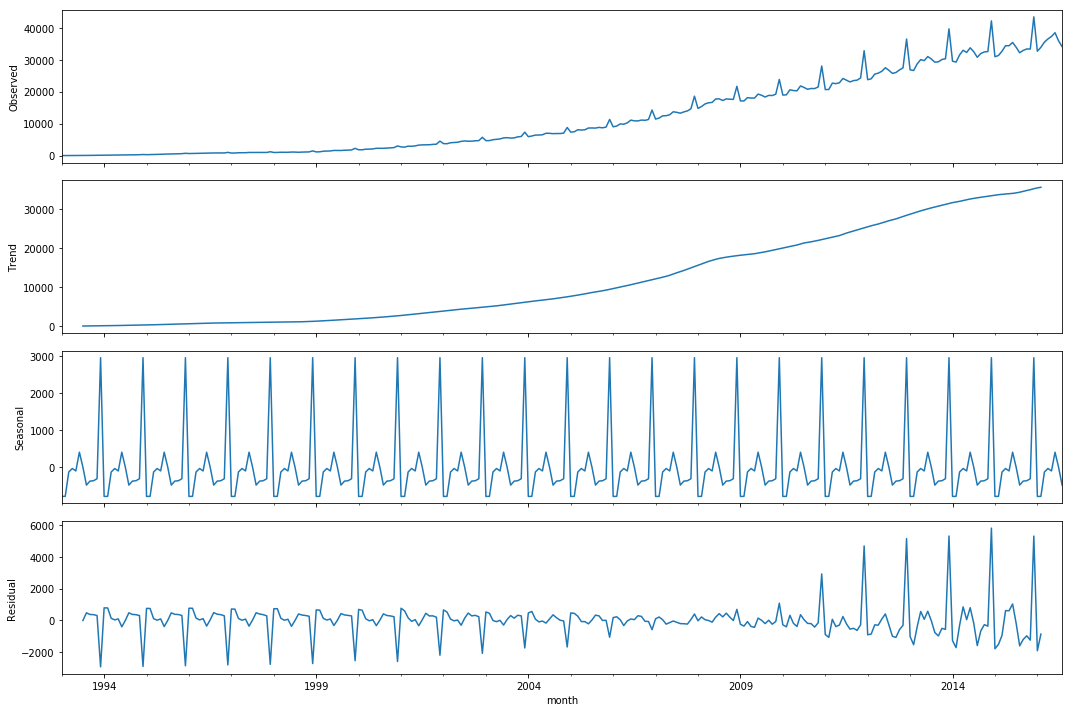

In [83]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(table).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(table.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


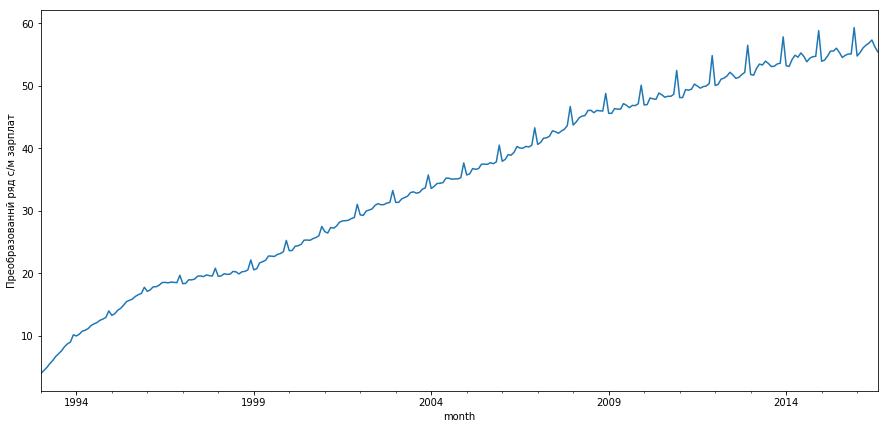

In [84]:
table['disp'], lmbda = stats.boxcox(table.WAG_C_M)
plt.figure(figsize(15,7))
table.disp.plot()
plt.ylabel(u'Преобразованнй ряд с/м зарплат')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(table.disp)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование (12 месяцев); сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


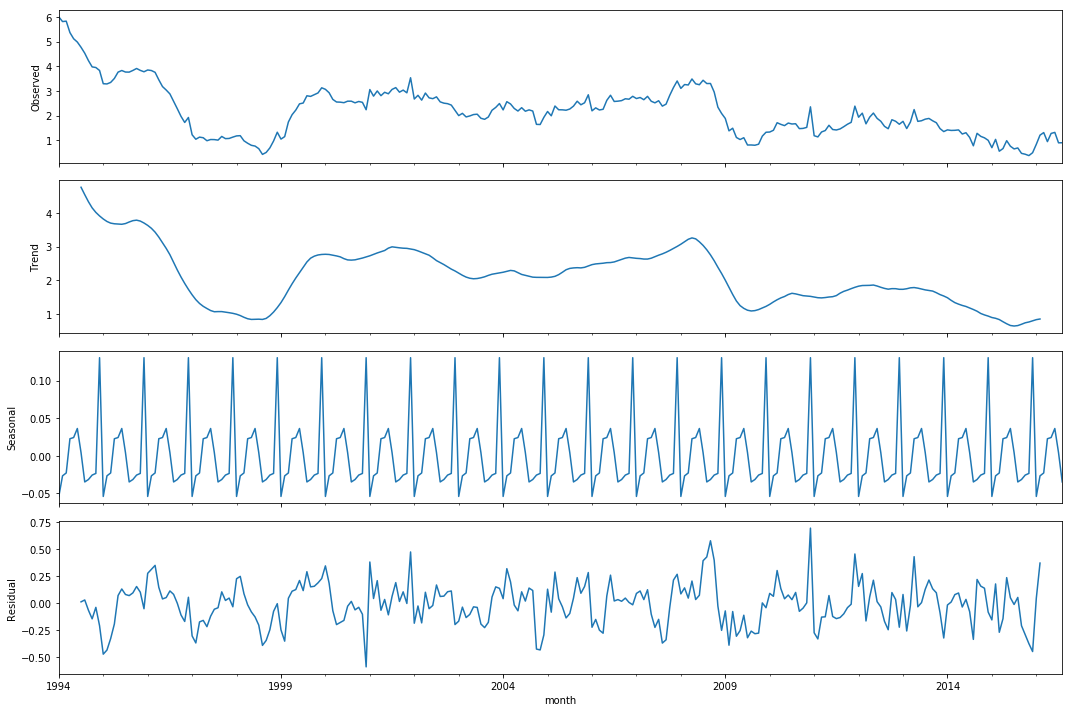

In [85]:
table['disp_diff'] = table.disp - table.disp.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(table.disp_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(table.disp_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


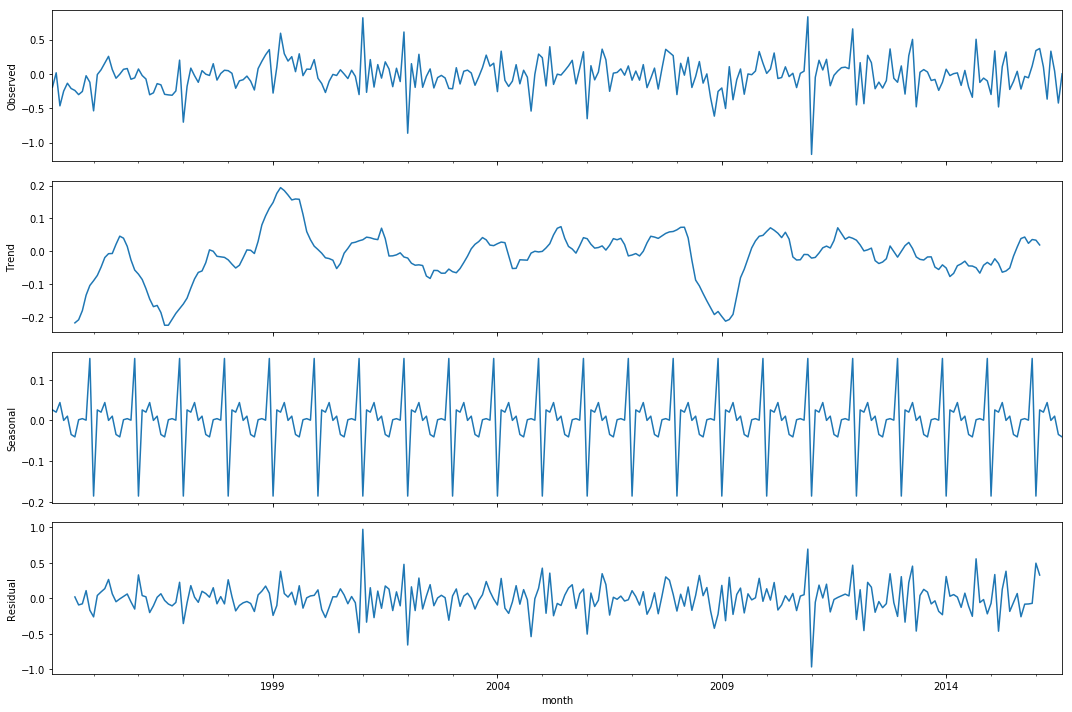

In [86]:
table['disp_diff2'] = table.disp_diff - table.disp_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(table.disp_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(table.disp_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

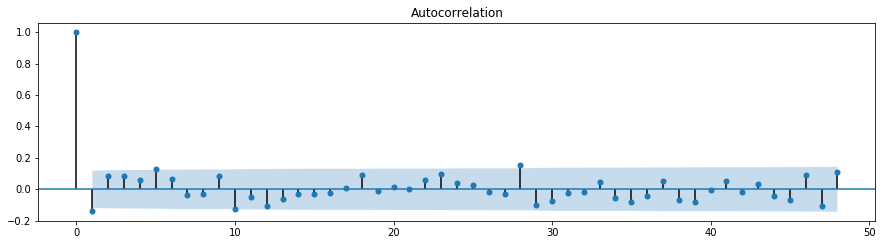

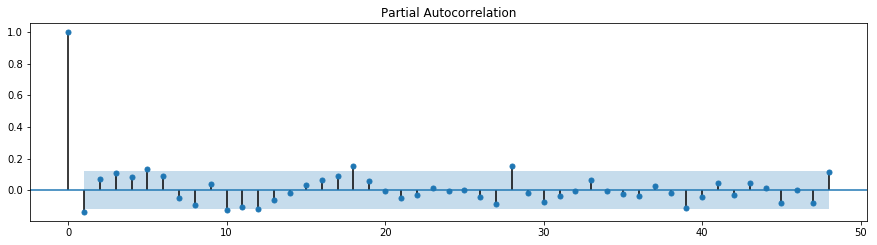

In [87]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(table.disp_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(table.disp_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

### Начальные приближения: Q=0, q=1, P=1, p=1

In [89]:
# Исключительно в целях эксперимента увеличил диапазон рассматриваемых значений макропараметров модели
ps = range(0, 2)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [90]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [91]:
#%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    print (param)
    try:
        model=sm.tsa.statespace.SARIMAX(table.disp, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
('wrong parameters:', (0, 0, 0, 0))
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 2, 0, 0)
('wrong parameters:', (1, 2, 0, 0))
(1, 2, 0, 1)
('wrong parameters:', (1, 2, 0, 1))
(1, 2, 1, 0)
('wrong parameters:', (1, 2, 1, 0))
(1, 2, 1, 1)
('wrong parameters:', (1, 2, 1, 1))


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [92]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
13  (1, 0, 1, 0)  0.340521
14  (1, 0, 1, 1)  0.492412
9   (0, 2, 1, 0)  0.509593
12  (1, 0, 0, 1)  0.774438
8   (0, 2, 0, 1)  0.880912


Лучшая модель:

In [93]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               disp   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 07 Aug 2018   AIC                              0.341
Time:                                    22:11:59   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090791
Критерий Дики-Фуллера: p=0.000003


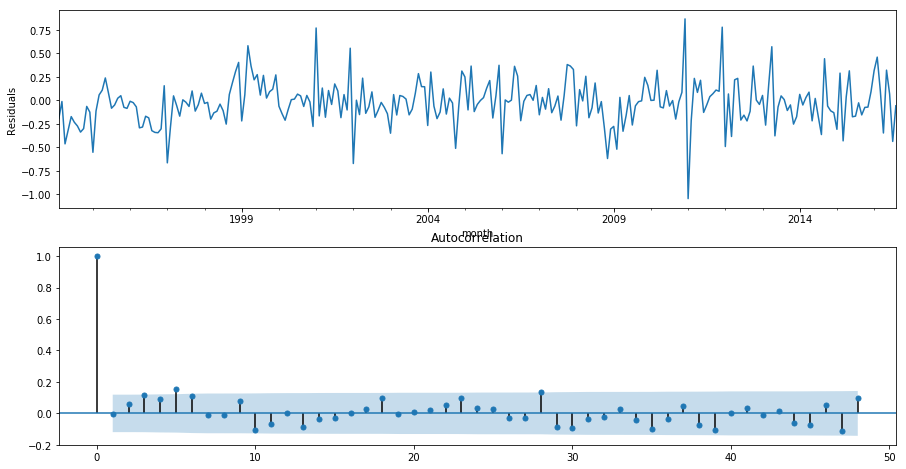

In [94]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

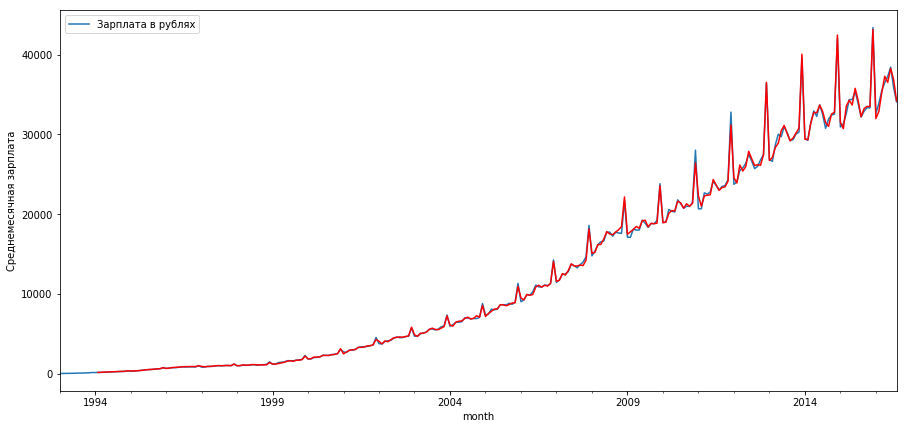

In [95]:
table['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
table.WAG_C_M.plot()
table.model[13:].plot(color='r')
plt.ylabel(u'Среднемесячная зарплата')
plt.legend([u'Зарплата в рублях'])
pylab.show()

### Прогноз

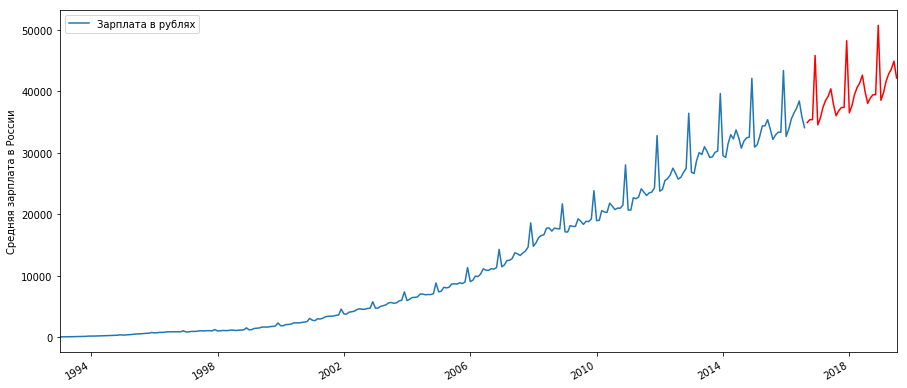

In [96]:
table2 = table[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= table2.columns)
table2 = pd.concat([table2, future])
table2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)
plt.figure(figsize(15,7))
table2.WAG_C_M.plot()
table2.forecast.plot(color='r')
plt.ylabel(u'Средняя зарплата в России')
plt.legend([u'Зарплата в рублях'])
pylab.show()